# Capstone project - IBM Data Science Certificate

## Open an Asian restuarant in Queens, New York City

# Introduction: Business problem

New York City is the largest city in the United States with over 8 million residents. The city is the home to people from a diverse set of backgrounds and ethnicities. Asian Americans make up 11.8% of the population, more than a million . It provides many business opportunities that can serve the Asian population in many ways, including food industry.
New York City has five boroughs, including Bronx, Manhattan, Queens, Staten Islands, and Brooklyn. Among these five boroughs, Queens has the biggest Asian population with more than 550,000 residents, according to the 2010 US census . 
In this project, I identify best neighborhoods in Queens to open an Asian restaurant based on three criteria: The total number of restaurants, the number of Asian restaurants, and the Asian population within a neighborhood. The best location has the minimum number of restaurants and a reasonable Asian population as the potential customers. 


# Data Selection 

To address the problem statement in this project, data are gathered through three sources as follows.

A. New York City dataset: The NYC data contains all five Boroughs, their Neighborhoods, and the coordinates that define their location. The dataset provides the ability to explore all the Neighborhoods in Queens.

B. Foursquare location dataset: The Foursquare dataset has the locations of different venues at each Neighborhood in Queens, NYC. The Foursquare API is used to gather restaurants and Asian restaurants of each neighborhood in order to identify the neighborhoods with minimum number of restaurants and Asian restaurants.

C. Asian population dataset: It provides the Asian population count and percentage in each Queens neighborhood. This dataset serves as the background information to assess whether a neighborhood has the potential customer base to support a new Asian Restaurant.


##### let's install and import all required libraries and then dive into the data exploratory part.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.9 MB/s  eta 0:00:01
Libraries imported.


### A. New York City Dataset

##### In order to segement the neighborhoods and explore them, let's download the New York dataset that contains all 5 boroughs, their neighborhoods, and latitude and logitude coordinates of each neighborhood.


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
#let's load the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
#let's get the feature of this json file and take a look at the first item in the list
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

###### Now, we should transform this Json list to a panda data frame for furhter analysis

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# create the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#take a look at the empty dataframe
neighborhoods


,Borough,Neighborhood,Latitude,Longitude


In [6]:
# let's fill the empty dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
#take a look at the first five rows
neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
#make sure if the data is fully loaded and has all rows and columns
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


##### getting the geograpical coordinate of New York City

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


##### Creating a map of New York with neighborhoods superimposed on top.

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

##### Let's slice the current dataframe and create a new one specifically for Queens Borough

In [11]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138
5,Queens,Corona,40.742382,-73.856825
6,Queens,Forest Hills,40.725264,-73.844475
7,Queens,Kew Gardens,40.705179,-73.829819
8,Queens,Richmond Hill,40.697947,-73.831833
9,Queens,Flushing,40.764454,-73.831773


##### Let's get the geoghraphical coordinates of Queens

In [12]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


##### Now, let's create a folium map that visualizes Queens and its neighborhoods 

In [13]:
# create map of Quens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

##### Now that we have information of all neighborhoods in Queens, let's use the Foursquare API to explore neighborhoods and their venues

### B. Foursquare location dataset

##### First, let's define Foursquare credentials and version:

In [14]:
CLIENT_ID = 'YMKTAVPSQ0KAZYWXTFEO3SDCHQH15UINIUW0OD5T030IZPXS' # your Foursquare ID
CLIENT_SECRET = '3OEKALLUZM234A2CG4IUAUE0LIR3YLFYIUW13V13FDFXO5FX' # your Foursquare Secret
VERSION = '20210411' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YMKTAVPSQ0KAZYWXTFEO3SDCHQH15UINIUW0OD5T030IZPXS
CLIENT_SECRET:3OEKALLUZM234A2CG4IUAUE0LIR3YLFYIUW13V13FDFXO5FX


##### Let's create a function to repeat the same process to all the neighborhoods in Queens


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, let's run the above function on each neighborhood and create a new dataframe called queens_venues.


In [16]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


Let's take a look at the first five rows of the data frame and its size

In [17]:
print(queens_venues.shape)
queens_venues.head()

(3785, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
2,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
4,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop


Let's see the total number of venues for each neighborhoods

In [18]:
queens_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,27,27,27,27,27,27
Astoria,100,100,100,100,100,100
Astoria Heights,33,33,33,33,33,33
Auburndale,67,67,67,67,67,67
Bay Terrace,40,40,40,40,40,40
Bayside,90,90,90,90,90,90
Bayswater,4,4,4,4,4,4
Beechhurst,33,33,33,33,33,33
Bellaire,30,30,30,30,30,30


Let's find out how many unique categories can be curated from all the returned venues


In [19]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))


There are 314 uniques categories.


### Analyzing each neighborhood

In [20]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,State / Provincia

In [21]:
print("The size of the new dataframe is", queens_onehot.shape)


The size of the new dataframe is (3785, 314)


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [22]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,Airport Lounge,Airport Service,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Residence Hall,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,State / Provincia

In [23]:
print("The size of this data frame is", queens_grouped.shape)

The size of this data frame is (81, 314)


In [24]:
# Writing a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for first five neighborhoods.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Donut Shop,Sandwich Place,Deli / Bodega,Metro Station,Bus Stop,Bank,BBQ Joint,Supermarket,Café
1,Astoria,Bar,Greek Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Pizza Place,Coffee Shop,Grocery Store,Sandwich Place,Bakery,Indian Restaurant
2,Astoria Heights,Rental Car Location,Bus Station,Chinese Restaurant,Bakery,Supermarket,Italian Restaurant,Moving Target,Bowling Alley,Baseball Field,Burger Joint
3,Auburndale,Greek Restaurant,Pizza Place,Korean Restaurant,Bank,Mattress Store,Mobile Phone Shop,Sushi Restaurant,Ice Cream Shop,Sandwich Place,Food Truck
4,Bay Terrace,Clothing Store,Women's Store,American Restaurant,Donut Shop,Shoe Store,Bank,Kids Store,Mobile Phone Shop,Cosmetics Shop,Shopping Mall


The data about top 10 venues are usefull, but we need to have a dataframe that specifically contains restaurants and Asian restaurants

In [26]:
queens_rest=queens_venues[queens_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
queens_rest.index=np.arange(1, len(queens_rest)+1)
print('The size of the dataframe that contains restuarants is:', queens_rest.shape)
queens_rest.head()

The size of the dataframe that contains restuarants is: (998, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
2,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
3,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
4,Astoria,40.768509,-73.915654,Duzan,40.768730,-73.911013,Falafel Restaurant
5,Astoria,40.768509,-73.915654,AbuQir Seafood,40.768577,-73.911169,Seafood Restaurant


In [27]:
queens_asianrest=queens_venues[queens_venues['Venue Category']=='Asian Restaurant'].reset_index(drop=True)
queens_asianrest.index=np.arange(1, len(queens_asianrest)+1)
print('The size of the dataframe that contains Asian restuarants is:', queens_asianrest.shape)
queens_asianrest.head()

The size of the dataframe that contains Asian restuarants is: (27, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Elmhurst,40.744049,-73.881656,Little House Cafe 聚香园茶餐厅,40.741853,-73.874486,Asian Restaurant
2,Forest Hills,40.725264,-73.844475,MoCA Asian Bistro,40.720983,-73.845436,Asian Restaurant
3,Forest Hills,40.725264,-73.844475,Asian Bowl,40.726644,-73.851988,Asian Restaurant
4,Flushing,40.764454,-73.831773,Peking Duck Sandwich Stall,40.758883,-73.829913,Asian Restaurant
5,Flushing,40.764454,-73.831773,趙記港式雲吞粥粉麵飯,40.758444,-73.831640,Asian Restaurant


As we see, there are 994 restuarants in Queens that 25 of them are Asian restuarants
Now, let's create a map of queens with its restuarants

In [28]:
# create map of Queens using latitude and longitude values
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(queens_rest['Venue Latitude'], queens_rest['Venue Longitude'], queens_rest['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  

# set color for Chinese restaurant

# add markers to map
for lat1, lng1, label1 in zip(queens_asianrest['Venue Latitude'], queens_asianrest['Venue Longitude'], queens_asianrest['Venue Category']):
    label1 = folium.Popup(label1, parse_html=True)
    folium.CircleMarker(
        [lat1, lng1],
        radius=5,
        popup=label1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  

# set color for Neighborhood center

for lat2, lng2, label2 in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label2= folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=4,
        popup=label2,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  
    
    
map_restaurants

In the above map, restarants are colored as blue and each Asian restaurant is shown with a red dot. Yellow dots show the neighborhood center.
Based on the map. restuarants are not equally distibuted and some neigborhoods have few number of Asian restaurants. This will be fully discussed later.
Now, Let's create a pana dataframe that shows the total number of restaurants and Asian restuarants for each neighborhood.

In [29]:
queens_rest_total = queens_rest.groupby('Neighborhood')['Venue Category'].count().reset_index()
queens_rest_total.rename(columns={'Venue Category' : 'Total Restaurants'}, inplace=True)

queens_rest['Asian Restaurant'] = np.where((queens_rest['Venue Category'] == 'Asian Restaurant'), 'True', 'False')
queens_rest['Asian Restaurant'].replace(to_replace=['False','True'], value=[0,1],inplace=True)
queens_asianrest_total = queens_rest.groupby('Neighborhood')['Asian Restaurant'].sum().reset_index()
queens_asianrest_total.rename(columns={'Asian Restaurant' : 'Total Asian Restaurants'}, inplace=True)

queens_rest_total_merge = queens_rest_total.merge(queens_asianrest_total, on=['Neighborhood'], how='inner')
queens_rest_total_merge 

,Neighborhood,Total Restaurants,Total Asian Restaurants
0,Arverne,1,0
1,Astoria,33,0
2,Astoria Heights,5,0
3,Auburndale,20,1
4,Bay Terrace,4,0
5,Bayside,30,2
6,Bayswater,1,0
7,Beechhurst,4,0
8,Bellaire,7,0
9,Belle Harbor,4,0


In [30]:
#save the dataframe
queens_rest_total.to_csv('queens_restaurants.csv')

### C. Queens Asian population


The data on Asian population of Queens is available on this website: https://statisticalatlas.com/county-subdivision/New-York/Queens-County/Queens/Race-and-Ethnicity#figure/neighborhood/asian

In [31]:
#read the data about the asian population of queens to a panda dataframe and see the first 5 rows

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_d1fcff17b7c4487e864d99844f815750 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_d1fcff17b7c4487e864d99844f815750 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_d1fcff17b7c4487e864d99844f815750 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9aQ1HBaC6qUl5myRqTLlEM1wSAlmgX_A2r5p-2npdagH',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_d1fcff17b7c4487e864d99844f815750)

body = client_d1fcff17b7c4487e864d99844f815750.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-lapi48jrcdiihg',Key='Asian_population_queens.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

asian_pop_queens = pd.read_csv(body)
asian_pop_queens.head()


,Neighborhood,% of Asian Population,Count,Rank
0,Flushing,71.00%,57.9k,1
1,Murray Hill,61.60%,46.8k,2
2,Jamaica Hills,60.20%,"7,632",3
3,Fresh Meadows,50.00%,11.6k,4
4,Elmhurst,49.60%,51.1k,5


In [32]:
asian_pop_queens.columns = [col.strip() for col in asian_pop_queens.columns]
asian_pop_queens.columns

Index(['Neighborhood', '% of Asian Population', 'Count', 'Rank'], dtype='object')

Let's clean the table a little bit. some neighborhood names should be changed and there are other minor changes

In [33]:
#Let's sort the neighborhoods in alphabetic order and drop nul values
asian_pop_queens.dropna(inplace=True)
asian_pop_queens.sort_values('Neighborhood', axis=0, inplace=True)
asian_pop_queens.reset_index(drop=True, inplace = True)
asian_pop_queens.head()

,Neighborhood,% of Asian Population,Count,Rank
0,Astoria,15.90%,26.8k,31
1,Auburndale,49.00%,13.0k,6
2,Bay Terrace,24.00%,"3,212",21
3,Bayside,43.50%,21.1k,7
4,Bellerose,38.80%,11.6k,11


In [34]:
#Let's clean the count columns. we should get rif of 'K','.', and ',' signs
asian_pop_queens['Count'] = asian_pop_queens['Count'].str.replace('k', '00', regex=True)
asian_pop_queens['Count']=asian_pop_queens['Count'].str.replace(',','')
asian_pop_queens['Count']=asian_pop_queens['Count'].str.replace('.','')
#df = pd.to_numeric(df, errors='coerce')
asian_pop_queens.head()


,Neighborhood,% of Asian Population,Count,Rank
0,Astoria,15.90%,26800,31
1,Auburndale,49.00%,13000,6
2,Bay Terrace,24.00%,3212,21
3,Bayside,43.50%,21100,7
4,Bellerose,38.80%,11600,11


In [35]:
#Let's clean the second column. better to rename the column and get rid of '%' and '.' sings. 
asian_pop_queens.rename(columns={'% of Asian Population' : 'Perctg_of_Asian_Population'}, inplace=True)
asian_pop_queens['Perctg_of_Asian_Population']=asian_pop_queens['Perctg_of_Asian_Population'].str.replace('%', '')

asian_pop_queens.head()

,Neighborhood,Perctg_of_Asian_Population,Count,Rank
0,Astoria,15.90,26800,31
1,Auburndale,49.00,13000,6
2,Bay Terrace,24.00,3212,21
3,Bayside,43.50,21100,7
4,Bellerose,38.80,11600,11


In [36]:
# make data types to float so that it is ready for further analysis
asian_pop_queens['Count']=asian_pop_queens.Count.astype('float64')
asian_pop_queens['Perctg_of_Asian_Population']=asian_pop_queens.Perctg_of_Asian_Population.astype('float64')
asian_pop_queens.dtypes


Neighborhood                   object
Perctg_of_Asian_Population    float64
Count                         float64
Rank                            int64
dtype: object

In [37]:
#some neighborhoods' names are incorrect or incomplete. Now, Let's rename such names so merging two tables becomes esiaer.
asian_pop_queens['Neighborhood']=asian_pop_queens['Neighborhood'].replace({"Cambria Hts":"Cambria Heights", 
                                                                        "Douglaston-Little Neck":"Douglaston", 
                                                                        "Jackson Hts":"Jackson Heights", 
                                                                        "Jamaica Ests":"Jamaica Estates",
                                                                        "Kew Gdns Hls":"Kew Gardens Hills",
                                                                        "Middle Vlg":"Middle Village",
                                                                        "Oakland Gdns":"Oakland Gardens",
                                                                        "Queens Vlg":"Queens Village",
                                                                        "S Ozone Pk":"South Ozone Park",
                                                                        "Springfield Gdns":"Springfield Gardens"
                                                                        })
asian_pop_queens.head()

,Neighborhood,Perctg_of_Asian_Population,Count,Rank
0,Astoria,15.9,26800.0,31
1,Auburndale,49.0,13000.0,6
2,Bay Terrace,24.0,3212.0,21
3,Bayside,43.5,21100.0,7
4,Bellerose,38.8,11600.0,11


Let's rename count columns to Asian population and also get the total population of rach neighborhodd and add it as a seperate columns. We also drop two columns as they are irrelevant to our purpose.

In [38]:
asian_pop_queens['Total_Population']=(asian_pop_queens['Count'] / asian_pop_queens['Perctg_of_Asian_Population']) * 100
asian_pop_queens['Total_Population']=asian_pop_queens.Total_Population.astype('int64')
asian_pop_queens.drop(['Rank', 'Perctg_of_Asian_Population'], axis=1, inplace=True)
asian_pop_queens.rename(columns={'Count' : 'Asian_Population'}, inplace=True)
asian_pop_queens.head()

,Neighborhood,Asian_Population,Total_Population
0,Astoria,26800.0,168553
1,Auburndale,13000.0,26530
2,Bay Terrace,3212.0,13383
3,Bayside,21100.0,48505
4,Bellerose,11600.0,29896


Now, Lets merge this tabe with the previous table on Queens restaurants.

In [39]:
queens_rest_pop_data = queens_rest_total_merge.merge(asian_pop_queens, on=['Neighborhood'], how='outer')
queens_rest_pop_data.head()

,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Arverne,1.0,0.0,NaN,NaN
1,Astoria,33.0,0.0,26800.0,168553.0
2,Astoria Heights,5.0,0.0,NaN,NaN
3,Auburndale,20.0,1.0,13000.0,26530.0
4,Bay Terrace,4.0,0.0,3212.0,13383.0


##### This table needs nome cleaning. Let's deal with Nan cells withthe folowwing codes

In [40]:
# Replace restaurants columns NaN with 0
queens_rest_pop_data['Total Restaurants']=queens_rest_pop_data['Total Restaurants'].replace(np.nan, 0)
queens_rest_pop_data['Total Asian Restaurants']=queens_rest_pop_data['Total Asian Restaurants'].replace(np.nan, 0)
# drop the Population data with NaN values
queens_rest_pop_data.dropna(inplace=True)
queens_rest_pop_data.reset_index(drop=True, inplace=True)
queens_rest_pop_data.head()

,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Astoria,33.0,0.0,26800.0,168553.0
1,Auburndale,20.0,1.0,13000.0,26530.0
2,Bay Terrace,4.0,0.0,3212.0,13383.0
3,Bayside,30.0,2.0,21100.0,48505.0
4,Bellerose,3.0,0.0,11600.0,29896.0


In [41]:
queens_rest_pop_data.to_csv('queens_rest_pop_data.csv')

# Methodology

Now that we obtained and cleaned our data from three data sources, we can delve into the analysis section. I will use a classification method to classify neighborhoods.
Let's perform the "Elbow" method to determine the best number of k for the Kmean engine. Once k is determined, I will proceed to classify the neighborhoods and label them by cluster.
Finally, the classified neighborhoods will be plotted by folium that can lead to the final notes and conclusion.

### Data Clustering

In [42]:
# Import required packages
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt        

In [43]:
# Input for clustering analysis are Number of Total Restaurants, Asian Restaurants, and Asian Populations.
X = queens_rest_pop_data[['Total Restaurants','Total Asian Restaurants', 'Asian_Population']]
X = preprocessing.MinMaxScaler().fit(X).transform(X)
X[0:3]

array([[0.62264151, 0.        , 0.46162102],
       [0.37735849, 0.33333333, 0.22272617],
       [0.0754717 , 0.        , 0.05328394]])

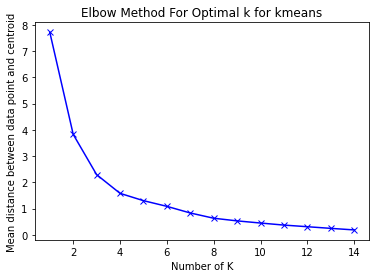

In [44]:
Ks = 15
sse = []

for n in range(1,Ks):
    
    #Train Model and Predict  
    k_means = KMeans(n_clusters = n, random_state=0)
    k_means.fit(X)
    sse.append(k_means.inertia_)

plt.plot(range(1,Ks),sse,'bx-')

plt.title('Elbow Method For Optimal k for kmeans')
plt.ylabel('Mean distance between data point and centroid')
plt.xlabel('Number of K')
plt.show()

###### Based on the above figure, K=4 is the most optimal number for clustering analysis.

In [45]:
k_means = KMeans(n_clusters = 4, random_state=0)
k_means.fit(X)
k_means.labels_[0:10]

array([0, 3, 2, 3, 2, 2, 2, 3, 2, 2], dtype=int32)

In [46]:
# add clustering labels
queens_rest_pop_data.insert(0, 'Cluster Labels', k_means.labels_)


# merge queens_rest_pop_data with queens_data to add latitude/longitude for each neighborhood
queens_data_merged = queens_data
queens_data_merged = queens_data_merged.join(queens_rest_pop_data.set_index('Neighborhood'), on='Neighborhood')

queens_data_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Queens,Astoria,40.768509,-73.915654,0.0,33.0,0.0,26800.0,168553.0
1,Queens,Woodside,40.746349,-73.901842,0.0,22.0,0.0,19700.0,48402.0
2,Queens,Jackson Heights,40.751981,-73.882821,0.0,46.0,0.0,13700.0,67156.0
3,Queens,Elmhurst,40.744049,-73.881656,1.0,53.0,1.0,51100.0,103024.0
4,Queens,Howard Beach,40.654225,-73.838138,2.0,15.0,0.0,994.0,26157.0


In [47]:
#drop NA values, change label name, and column types
queens_data_merged.dropna(inplace=True)
queens_data_merged.reset_index(drop=True, inplace=True)
queens_data_merged.rename(columns={'Cluster Labels' : 'Cluster_Labels'}, inplace=True)
queens_data_merged['Cluster_Labels']=queens_data_merged.Cluster_Labels.astype('int64')
queens_data_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Queens,Astoria,40.768509,-73.915654,0,33.0,0.0,26800.0,168553.0
1,Queens,Woodside,40.746349,-73.901842,0,22.0,0.0,19700.0,48402.0
2,Queens,Jackson Heights,40.751981,-73.882821,0,46.0,0.0,13700.0,67156.0
3,Queens,Elmhurst,40.744049,-73.881656,1,53.0,1.0,51100.0,103024.0
4,Queens,Howard Beach,40.654225,-73.838138,2,15.0,0.0,994.0,26157.0


### Visualizing the clusters

In [48]:
# create map
n_clusters = 4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_data_merged['Latitude'], queens_data_merged['Longitude'], queens_data_merged['Neighborhood'], queens_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the above map, cluster one is represented by red dots, cluster 2 is purple, cluster 3 is blue and cluster 4 is green. 

#### Cluster 1

In [49]:
queens_data_merged.loc[queens_data_merged['Cluster_Labels'] == 0, queens_data_merged.columns[[1] + list(range(5, queens_data_merged.shape[1]))]]


,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Astoria,33.0,0.0,26800.0,168553.0
1,Woodside,22.0,0.0,19700.0,48402.0
2,Jackson Heights,46.0,0.0,13700.0,67156.0
43,Jamaica Hills,22.0,0.0,7632.0,12677.0


#### Cluster 2

In [50]:
queens_data_merged.loc[queens_data_merged['Cluster_Labels'] == 1, queens_data_merged.columns[[1] + list(range(5, queens_data_merged.shape[1]))]]


,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
3,Elmhurst,53.0,1.0,51100.0,103024.0
9,Flushing,42.0,3.0,57900.0,81549.0
38,Murray Hill,35.0,2.0,46800.0,75974.0


#### Cluster 3

In [51]:
queens_data_merged.loc[queens_data_merged['Cluster_Labels'] == 2, queens_data_merged.columns[[1] + list(range(5, queens_data_merged.shape[1]))]]


,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
4,Howard Beach,15.0,0.0,994.0,26157.0
5,Corona,11.0,0.0,12600.0,109565.0
7,Kew Gardens,17.0,0.0,4435.0,24103.0
8,Richmond Hill,13.0,0.0,17300.0,54920.0
12,Maspeth,7.0,0.0,9042.0,51084.0
13,Ridgewood,19.0,0.0,5440.0,66341.0
14,Glendale,3.0,0.0,1230.0,31538.0
17,Ozone Park,5.0,0.0,16600.0,54426.0
18,South Ozone Park,1.0,0.0,17100.0,74025.0
23,Douglaston,15.0,0.0,9474.0,24801.0


#### Cluster 4

In [52]:
queens_data_merged.loc[queens_data_merged['Cluster_Labels'] == 3, queens_data_merged.columns[[1] + list(range(5, queens_data_merged.shape[1]))]]


,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
6,Forest Hills,19.0,2.0,18100.0,69348.0
10,Sunnyside,21.0,1.0,11300.0,47083.0
11,East Elmhurst,9.0,1.0,13900.0,64351.0
15,Rego Park,22.0,1.0,12200.0,42807.0
16,Woodhaven,18.0,1.0,7786.0,37076.0
19,College Point,12.0,2.0,8409.0,26114.0
20,Whitestone,5.0,1.0,9114.0,40149.0
21,Bayside,30.0,2.0,21100.0,48505.0
22,Auburndale,20.0,1.0,13000.0,26530.0
28,Oakland Gardens,18.0,1.0,10000.0,23474.0


# Analysis

The neighborhoods in cluster 1 have no Asian restaurants and considerable Asian population, however, there are plenty of restaurants that makes the business environment very competitive. The cluster 2 includes neighborhoods with high Asian population and high number of restaurants. There are also 1-3 Asian restaurants in each neighborhood. Cluster 3 contains neighborhoods with low number of restaurants. Most neighborhoods have less than 10 restaurants and there is no single Asian restaurant in any neighborhood within this cluster. While Asian population is low in some areas, in some other neighborhoods there are enough people as the potential customers of a new Asian restaurant. Cluster 4 has 1-2 Asian restaurants in each neighborhood with medium Asian population, which means that these neighborhoods are well served and offer low potential for a new Asian restaurant.

Now, we will focus on cluster 3 and choose a few neighborhoods which are more populouus and have less restuarants. 

In [59]:
#Let's put all neighborhoods in cluster 3 into a new dataframe and sort if by Asian population. We will then choose our top choices among the first 10 neighborhoods.
rest_plot = queens_data_merged.loc[queens_data_merged['Cluster_Labels'] == 2, queens_data_merged.columns[[1] + list(range(5, queens_data_merged.shape[1]))]]
rest_plot.sort_values('Asian_Population', axis=0, ascending=False, inplace=True)
rest_plot.reset_index(drop=True, inplace=True)
rest_plot.head(10)

,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,Richmond Hill,13.0,0.0,17300.0,54920.0
1,South Ozone Park,1.0,0.0,17100.0,74025.0
2,Ozone Park,5.0,0.0,16600.0,54426.0
3,Corona,11.0,0.0,12600.0,109565.0
4,Bellerose,3.0,0.0,11600.0,29896.0
5,Fresh Meadows,11.0,0.0,11600.0,23200.0
6,Douglaston,15.0,0.0,9474.0,24801.0
7,Kew Gardens Hills,5.0,0.0,9474.0,41735.0
8,Maspeth,7.0,0.0,9042.0,51084.0
9,Briarwood,10.0,0.0,8153.0,27921.0


In [62]:
#put the first 10 rows in a new datarame and sort by tota number of restaurant in decsending order
rest_plot_final = rest_plot.head(10)
rest_plot_final.sort_values('Total Restaurants', axis=0, ascending=True, inplace=True)
rest_plot_final.reset_index(drop=True, inplace=True)
rest_plot_final.head(3)

,Neighborhood,Total Restaurants,Total Asian Restaurants,Asian_Population,Total_Population
0,South Ozone Park,1.0,0.0,17100.0,74025.0
1,Bellerose,3.0,0.0,11600.0,29896.0
2,Ozone Park,5.0,0.0,16600.0,54426.0


# Results and Discussion

As it is illustrated in the K-means clustering analysis, the neighborhoods in Queens are divided into 4 clusters based on 3 factors: Total restaurants, Asian restaurants, and Asian population. 

The neighborhoods in cluster 1 have no Asian restaurants and medium to high Asian population, however, there are plenty of restaurants that makes the business environment very competitive. The cluster 2 includes neighborhoods with high Asian population and high number of restaurants. There are also 1-3 Asian restaurants in each neighborhood. It means that this cluster does not offer a good spot for our purpose. Cluster 4 has 1-2 Asian restaurants in each neighborhood with medium Asian population, which means that these neighborhoods are well served and offer low potential for a new Asian restaurant. 

Cluster 3 contains neighborhoods with low number of restaurants. Most neighborhoods have less than 10 restaurants and there is no single Asian restaurant in any neighborhood within this cluster. While Asian population is low in some areas, in some other neighborhoods there are enough people as the potential customers of a new Asian restaurant. This cluster has some ideal neighborhoods for opening a new Asian restaurant.

# Conclusion

Among 27 neighborhoods in the third cluster, only 6 of them have more than 10,000 Asian population, which can be seen as the potential customers for our Asian restaurant. To further narrow the choices, we look at the total number of restaurants in these neighborhoods.  In three neighborhoods, there are zero Asian restaurants and less than 5 restaurants in general, which means that the there is a great potential for profitability with minimal number of competitors.  

South Ozone Park neighborhood is the top choice. It is located in the southern part of Queens, it has zero Asian population, there is only one restaurant in the neighborhood and around 17100 Asian live in the area. A new restaurant can target this population while there is almost no competitor in this neighborhood.

The second and third choices are Bellerose and Ozone Park neighborhood. Ozone Park is located next to the South Ozone Park, our top choice. It has no Asian restaurant and there are only five restaurants in the area. It is a home to more than 16000 Asian residents which is a considerable base for our business. Bellerose neighborhood is located in the middle of Queens, it has no Asian restaurant and only 3 restaurants exist in the area. More than 11000 Asian people live in this neighborhood who can be the potential customers of our Asian restaurant. 
